In [2]:
import requests
import json
import pandas as pd
import numpy as np
from time import sleep
from datetime import datetime, timezone
from datetime import time



import matplotlib.pyplot as plt
import matplotlib

from utils import get_block_number_from_timestamp


# Timestamp - block

Load previously fetched data

In [24]:
df_timestamp_block_origin = pd.read_csv('./daily_data/timestamp_block.csv')

print("Origin date fetch (UTC):", datetime.utcfromtimestamp(df_timestamp_block_origin['timestamp'].iloc[-1]))

Origin date fetch (UTC): 2022-07-30 00:00:00


Query new timestamp-block

In [36]:
origin_timestamp = df_timestamp_block_origin['timestamp'].iloc[-1]
dt = datetime.now()
last_timestamp = int(datetime(
    year=dt.year, month=dt.month, day=dt.day, 
    hour=0, minute=0, second=0, microsecond=0, 
    tzinfo=timezone.utc
).timestamp())

interval = 86400 # 1 day
df_timestamp_block = df_timestamp_block_origin

for timestamp in range(origin_timestamp, last_timestamp+1, interval):
    block = get_block_number_from_timestamp(timestamp)
    values = [{
        "timestamp": timestamp,
        "block": block
    }]
    df_timestamp_block = df_timestamp_block.append(values)
    sleep(0.25)

# not sure why got many duplicated, just use drop
df_timestamp_block.drop_duplicates(keep='first', inplace=True) 

# save
df_timestamp_block.reset_index(inplace = True, drop = True)
df_timestamp_block.to_csv('./daily_data/timestamp_block.csv', index=False)

print("Last date fetch (UTC):", datetime.utcfromtimestamp(df_timestamp_block['timestamp'].iloc[-1]))


1659139200
Last date fetch (UTC): 2022-07-30 00:00:00


# Global statistics

Load previously fetched data

In [ ]:
df_global_statistics =  pd.read_csv('./daily_data/global_statistics.csv')

Query new global statistics data

In [4]:
base_url = "https://v4.subgraph.polygon.oceanprotocol.com"
route = "/subgraphs/name/oceanprotocol/ocean-subgraph"
url = base_url + route

In [4]:
for i in range(df_timestamp_block_origin.shape[0], df_timestamp_block.shape[0], 1): 
  block = df_timestamp_block['block'][i]
  timestamp = df_timestamp_block['timestamp'][i]
  query = \
  f"""
    {{
      globalStatistics (
        block: {{
          number: {block}
        }}
      ) 
      {{
        nftCount
        datatokenCount
        totalLiquidity {{
          value
          token {{
            address
          }}
        }}
        poolCount
        fixedCount
      }}
    }}
  """
  headers = {"Content-Type": "application/json"}
  payload = json.dumps({"query": query})
  response = requests.request("POST", url, headers=headers, data=payload)
  data = json.loads(response.text)

  df_data = pd.json_normalize(
    data['data']['globalStatistics'],
    record_path=['totalLiquidity'],
    meta=['datatokenCount','fixedCount','nftCount','poolCount']
  )
  df_data.rename({'value': 'totalLiquidity.value', 'token.address': 'totalLiquidity.token.address'}, axis=1, inplace=True)
  
  df_data['block'] = block
  df_data['timestamp'] = timestamp

  df_global_statistics = pd.concat([df_global_statistics, df_data], ignore_index=True, sort=False)

In [5]:
df_global_statistics.drop_duplicates(keep=False, inplace=True) # just drop_duplicates to be safe
df_global_statistics.to_csv('./daily_data/global_statistics.csv', index=False)

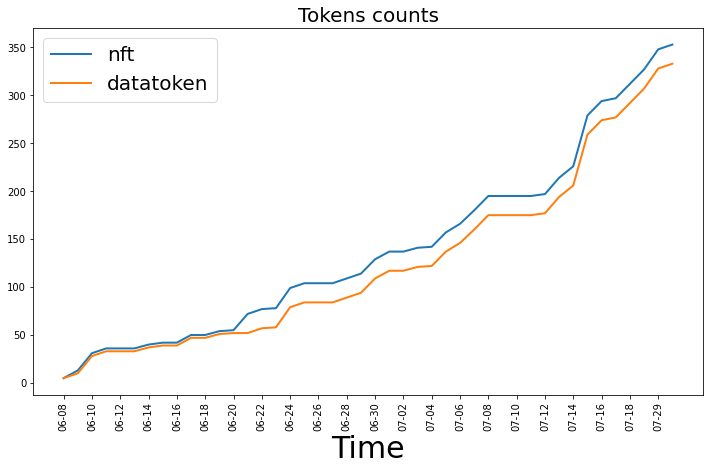

In [6]:
fig, ax = plt.subplots()
x = pd.to_datetime(df_global_statistics["timestamp"], unit='s').dt.strftime('%m-%d')

y = df_global_statistics['nftCount'].astype(float)
plt.plot(x, y, label = 'nft', linewidth=2)

y = df_global_statistics['datatokenCount']
plt.plot(x, y, label = 'datatoken', linewidth=2)


plt.xlabel("Time", fontsize=30)
# plt.ylabel("Number of tokens", fontsize=16)
plt.title(f"Tokens counts", fontsize=20)
plt.xticks(rotation=30)
plt.legend(fontsize=20)

ax.tick_params(axis='x',rotation=90)

ax.set_xticks(x[0::2])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

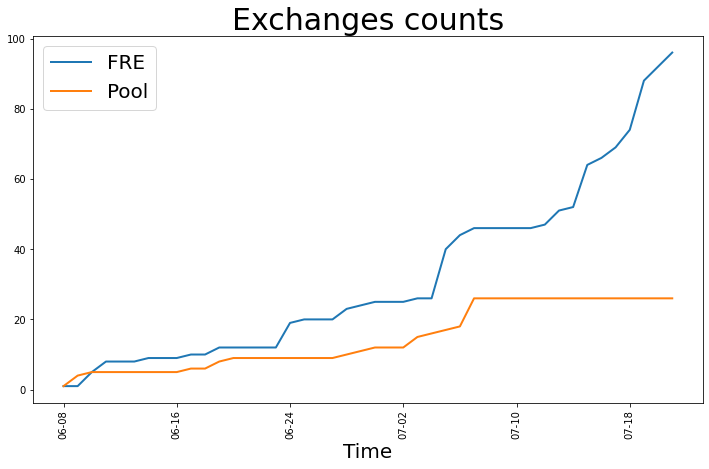

In [7]:
fig, ax = plt.subplots()
x = pd.to_datetime(df_global_statistics["timestamp"], unit='s').dt.strftime('%m-%d')

y = df_global_statistics['fixedCount'].astype(float)
plt.plot(x, y, label = 'FRE', linewidth=2)

y = df_global_statistics['poolCount']
plt.plot(x, y, label = 'Pool', linewidth=2)

plt.title(f"Exchanges counts", fontsize=30)
plt.xlabel("Time", fontsize=20)
# plt.ylabel("Number of tokens", fontsize=16)

plt.xticks(rotation=30)
plt.legend(fontsize=20)

ax.tick_params(axis='x',rotation=90)
ax.set_xticks(x[0::8])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

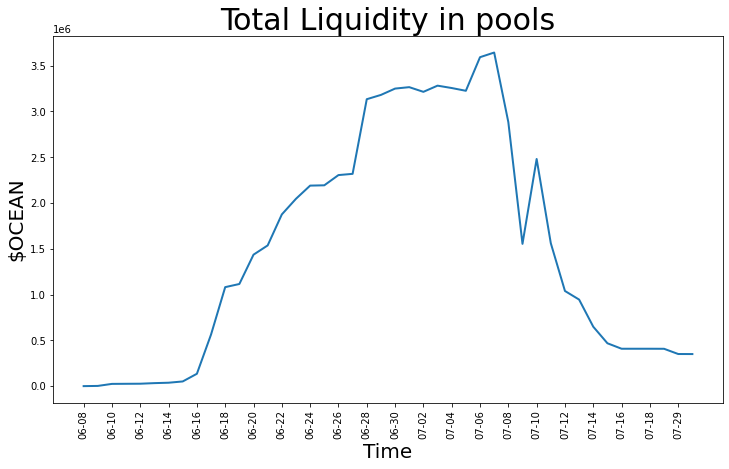

In [13]:
fig, ax = plt.subplots()
x = pd.to_datetime(df_global_statistics["timestamp"], unit='s').dt.strftime('%m-%d')

y = df_global_statistics['totalLiquidity.value'].astype(float)
plt.plot(x, y, label = 'Total Liquidity in pools', linewidth=2)

plt.title(f"Total Liquidity in pools", fontsize=30)

plt.xlabel("Time", fontsize=20)
plt.ylabel("$OCEAN", fontsize=20)
plt.xticks(rotation=30)
# plt.legend(fontsize=10)

ax.tick_params(axis='x',rotation=90)

ax.set_xticks(x[0::2])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

# Datatokens
just get list of datatokens at querying time, is it in fre, pool, dispenser, or none, this query doesn't need timestamp-block

## Query

In [5]:
query = \
"""
{
  tokens (
    where: {isDatatoken: true}
    orderBy: createdTimestamp
    orderDirection:asc
    first: 1000
  ) 
  {
    address
    createdTimestamp
    block
    pools {
      id
    }
    fixedRateExchanges {
      id
    }
    dispensers {
      id
    }
  }
}
 
"""
headers = {"Content-Type": "application/json"}
payload = json.dumps({"query": query})
response = requests.request("POST", url, headers=headers, data=payload)

data = json.loads(response.text)
df_datatokens = pd.json_normalize(data['data']['tokens'])

Clean and save

In [7]:
df_datatokens['fixedRateExchanges'] = df_datatokens['fixedRateExchanges'].apply(lambda y: y[0]['id'] if len(y)>0 else np.nan)
df_datatokens['pools'] = df_datatokens['pools'].apply(lambda y: y[0]['id'] if len(y)>0 else np.nan)
df_datatokens['dispensers'] = df_datatokens['dispensers'].apply(lambda y: y[0]['id'] if len(y)>0 else np.nan)

df_datatokens.to_csv('./daily_data/datatokens.csv', index=False)
df_datatokens.head()

,address,block,createdTimestamp,dispensers,fixedRateExchanges,pools
0,0xb5d8d705524a18056216bf552fa7b473f852bf48,28944565,1653897180,0x257fe2e49530a4b7fc3ed597465e2931db3f20b7-0xb...,NaN,NaN
1,0x1c5d7f3c7c760d7d47823b0f0369940c71874e95,28979255,1653972787,0x257fe2e49530a4b7fc3ed597465e2931db3f20b7-0x1...,NaN,NaN
2,0x8b57ed8dcb403125912d4e8a4c15a6d50a517df2,28985213,1653985350,NaN,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...,NaN
3,0xddc5acf6b81520802adbf4f24e05de7fc2cac467,29064268,1654153299,0x257fe2e49530a4b7fc3ed597465e2931db3f20b7-0xd...,NaN,NaN
4,0xd3e5af97ac3ec333d6410ff807c217b090c88e61,29294034,1654645651,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a


# Pools

In [15]:
df_datatokens_pools = df_datatokens.dropna(subset=['pools']).reset_index(drop=True)
print(f'Number of datatokens which created liquidity pool: {df_datatokens_pools.shape[0]}')
df_datatokens_pools.head()

Number of datatokens which created pool: 26


,index,address,block,createdTimestamp,fixedRateExchanges,pools
0,4,0xd3e5af97ac3ec333d6410ff807c217b090c88e61,29294034,1654645651,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a
1,5,0xbf2fac00970223da63affd7a58e6ea5f53a9bf38,29313935,1654688214,NaN,0xbae67c3f5ea82a1c9b1a5c442f5af2d8a80dbf84
2,6,0xdf71733d8d8bc83fb7caf48525716938fa2241e6,29320012,1654701647,NaN,0x2dd64ba8d9b9b1bb402aa70214e1fb1d7af314a1
3,9,0x473851e703c9e7f46e88b6552ddf8f47fd7dd460,29327479,1654717071,NaN,0xa6fe1df0e3ae0aa0d84f4beb0c626add65d971b1
4,26,0xf807ca842d8fb217fcf0a0df8e84e447358c6e86,29349611,1654764650,NaN,0x95f57249e6dd394318025068a8bfc841ac6ec0dd


Load fetched data

In [ ]:
df_pools = pd.read_csv('./daily_data/pools.csv')

Query new data

In [52]:
for i in range(df_datatokens_pools.shape[0]): # still query all available pools
    pool = '"' + df_datatokens_pools['pools'][i] + '"'
    for j in range(df_timestamp_block_origin.shape[0], df_timestamp_block.shape[0], 1): # recent timestamp-block
        block = df_timestamp_block['block'][j]
        timestamp = df_timestamp_block['timestamp'][j]
        query = \
        f"""
            {{
                pool (
                    id: {pool}
                    block: {{
                    number: {block}
                    }}
                ) {{
                    id
                    baseTokenLiquidity
                    datatokenLiquidity
                    spotPrice
                    swapCount
                    joinCount
                    exitCount
                    transactionCount
                    datatoken {{
                    address
                    name
                    symbol
                    orderCount
                    holderCount
                    nft {{
                        creator
                        owner
                        name
                        symbol
                        transferable
                        
                    }}
                    }}
                }}
            }}
        """
        headers = {"Content-Type": "application/json"}
        payload = json.dumps({"query": query})
        response = requests.request("POST", url, headers=headers, data=payload)

        data = json.loads(response.text)
        if data['data']['pool'] is not None:
            df_data = pd.json_normalize(data['data']['pool'])
            df_data['block'] = block
            df_data['timestamp'] = timestamp
        else:
            df_data = pd.DataFrame([[np.nan]*20],columns=df_pools.columns)
            df_data['id'] = df_datatokens_pools['pools'][i]
            df_data['block'] = block
            df_data['timestamp'] = timestamp
        df_pools = pd.concat([df_pools, df_data], ignore_index=True, sort=False)
df_pools

,baseTokenLiquidity,datatokenLiquidity,exitCount,id,joinCount,spotPrice,swapCount,transactionCount,datatoken.address,datatoken.holderCount,datatoken.name,datatoken.nft.creator,datatoken.nft.name,datatoken.nft.owner,datatoken.nft.symbol,datatoken.nft.transferable,datatoken.orderCount,datatoken.symbol,block,timestamp
0,292.02344398292613233,24230.995018928972416557,0,0x25faf893edcef3b1c94029f01a088448669fcb9a,323,0.0102077466014217030825970557789894,0,323,0xd3e5af97ac3ec333d6410ff807c217b090c88e61,0,Uxorious Seal Token,0x99840df5cb42fabe0feb8811aaa4bc99ca6c84e0,Ocean Data NFT,0x99840df5cb42fabe0feb8811aaa4bc99ca6c84e0,OCEAN-NFT,1.0,6,UXOSEA-33,31001552,1658469600
1,NaN,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28931584,1653868800
2,NaN,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28971170,1653955200
3,NaN,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29011769,1654041600
4,NaN,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29052216,1654128000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,0.068133781696625922,0.043911293957940654,0,0x3fdc6cf954620762ecaadbc9366b8a4e0bdfd0ae,66,1.317328082288838160151816620459896,0,66,0x16d2cee4c91d4a61c234b375fb977616bcabb5c7,0,Kind Anemone Token,0xd30dd83132f2227f114db8b90f565bca2832afbd,Ocean Data NFT,0xd30dd83132f2227f114db8b90f565bca2832afbd,OCEAN-NFT,1.0,2,KINANE-81,30768848,1657929600
1349,0.068133781696625922,0.043911293957940654,0,0x3fdc6cf954620762ecaadbc9366b8a4e0bdfd0ae,66,1.317328082288838160151816620459896,0,66,0x16d2cee4c91d4a61c234b375fb977616bcabb5c7,0,Kind Anemone Token,0xd30dd83132f2227f114db8b90f565bca2832afbd,Ocean Data NFT,0xd30dd83132f2227f114db8b90f565bca2832afbd,OCEAN-NFT,1.0,2,KINANE-81,30803671,1658016000
1350,0.068133781696625922,0.043911293957940654,0,0x3fdc6cf954620762ecaadbc9366b8a4e0bdfd0ae,66,1.317328082288838160151816620459896,0,66,0x16d2cee4c91d4a61c234b375fb977616bcabb5c7,0,Kind Anemone Token,0xd30dd83132f2227f114db8b90f565bca2832afbd,Ocean Data NFT,0xd30dd83132f2227f114db8b90f565bca2832afbd,OCEAN-NFT,1.0,2,KINANE-81,30841011,1658102400
1351,0.068133781696625922,0.043911293957940654,0,0x3fdc6cf954620762ecaadbc9366b8a4e0bdfd0ae,66,1.317328082288838160151816620459896,0,66,0x16d2cee4c91d4a61c234b375fb977616bcabb5c7,0,Kind Anemone Token,0xd30dd83132f2227f114db8b90f565bca2832afbd,Ocean Data NFT,0xd30dd83132f2227f114db8b90f565bca2832afbd,OCEAN-NFT,1.0,2,KINANE-81,30878163,1658188800


In [ ]:
# save
df_pools.to_csv('./daily_data/pools.csv', index=False)

## plots

sort pools by max liquidity

In [63]:
df_pools_sorted = pd.DataFrame(columns = ['id', 'maxLiquidity'])

for pool in df_pools['id'].unique():
    df = df_pools.loc[df_pools['id'] == pool]
    values = [{
        "id": pool,
        "maxLiquidity": df['baseTokenLiquidity'].astype(float).max()
    }]
    df_pools_sorted = df_pools_sorted.append(values)

df_pools_sorted = df_pools_sorted.sort_values('maxLiquidity', ascending=False).reset_index(drop=True)
df_pools_sorted.head(10)

,id,maxLiquidity
0,0x95f57249e6dd394318025068a8bfc841ac6ec0dd,2.120996e+06
1,0x193f1ce9108644cd4d09c769d8dcd100f2b901d6,1.607907e+06
2,0xa6fe1df0e3ae0aa0d84f4beb0c626add65d971b1,9.992493e+05
3,0x5282476fad14439cb8e66d6734a24598d3da7946,5.418177e+05
4,0x56a5cf2fb3f5b12e6c4bc4c0f100800d3735e522,3.263109e+05
5,0x569c692125cf32baf19e4ce713f9cf43e4c18c2c,9.502719e+04
6,0x1f5927cb77ea8449f0281ed14847a70d7a4f7053,4.159860e+04
7,0x800d0c1e4fb219a2d9bd2f292aa91abdcd862915,2.400787e+04
8,0xe7832a036da14dc3bbcec5f73a8193221e9f0da5,2.228288e+04
9,0x25faf893edcef3b1c94029f01a088448669fcb9a,8.235208e+03


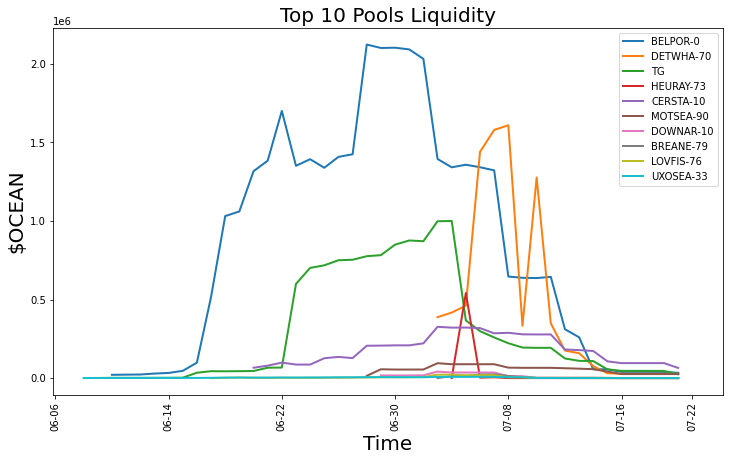

In [64]:
fig, ax = plt.subplots()
for pool in df_pools_sorted['id'][:10]:
    df = df_pools.loc[df_pools['id'] == pool]
    if df['datatoken.name'].unique()[0] is np.nan:
        datatoken_name = df['datatoken.name'].unique()[1]
    else:
        datatoken_name = df['datatoken.name'].unique()[0]

    if df['datatoken.symbol'].unique()[0] is np.nan:
        datatoken_symbol = df['datatoken.symbol'].unique()[1]
    else:
        datatoken_symbol = df['datatoken.symbol'].unique()[0]
    
    x = pd.to_datetime(df["timestamp"], unit='s').dt.strftime('%m-%d')

    y = df['baseTokenLiquidity'].astype(float)
    plt.plot(x, y, label = f'{datatoken_symbol}', linewidth=2)

plt.xlabel("Time", fontsize=20)
plt.ylabel("$OCEAN", fontsize=20)
plt.title(f"Top 10 Pools Liquidity", fontsize=20)
plt.xticks(rotation=30)
plt.legend(fontsize=10)

ax.tick_params(axis='x',rotation=90)

ax.set_xticks(x[0::8])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

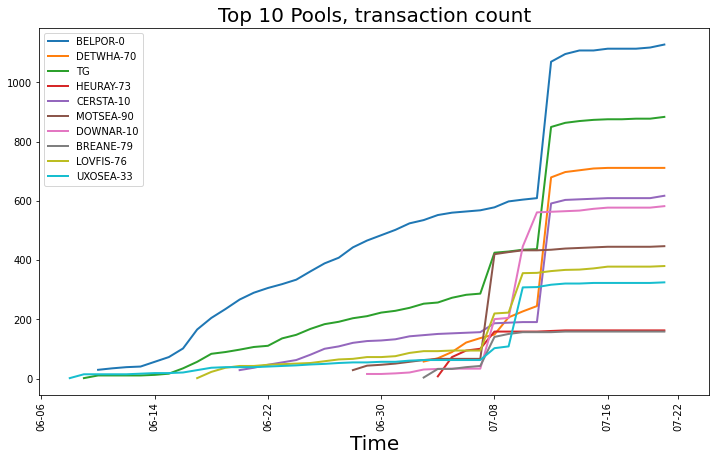

In [66]:
fig, ax = plt.subplots()
for pool in df_pools_sorted['id'][:10]:
    df = df_pools.loc[df_pools['id'] == pool]
    if df['datatoken.name'].unique()[0] is np.nan:
        datatoken_name = df['datatoken.name'].unique()[1]
    else:
        datatoken_name = df['datatoken.name'].unique()[0]

    if df['datatoken.symbol'].unique()[0] is np.nan:
        datatoken_symbol = df['datatoken.symbol'].unique()[1]
    else:
        datatoken_symbol = df['datatoken.symbol'].unique()[0]
    
    x = pd.to_datetime(df["timestamp"], unit='s').dt.strftime('%m-%d')

    y = df['transactionCount'].astype(float)
    plt.plot(x, y, label = f'{datatoken_symbol}', linewidth=2)

plt.xlabel("Time", fontsize=20)
# plt.ylabel("$OCEAN", fontsize=20)
plt.title(f"Top 10 Pools, transaction count", fontsize=20)
plt.xticks(rotation=30)
plt.legend(fontsize=10)

ax.tick_params(axis='x',rotation=90)

ax.set_xticks(x[0::8])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

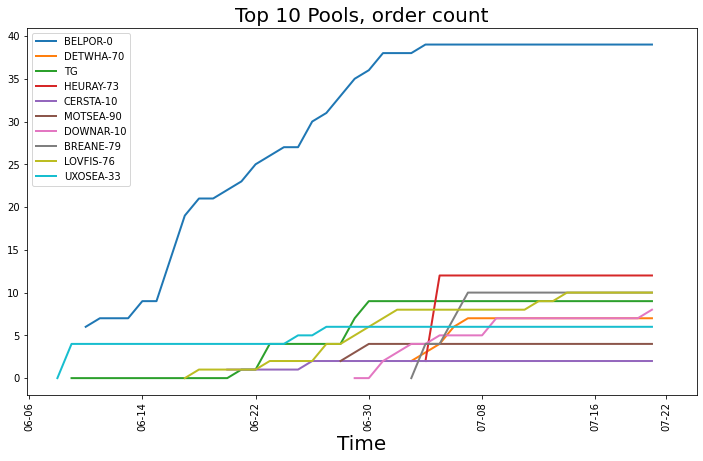

In [68]:
fig, ax = plt.subplots()
for pool in df_pools_sorted['id'][:10]:
    df = df_pools.loc[df_pools['id'] == pool]
    if df['datatoken.name'].unique()[0] is np.nan:
        datatoken_name = df['datatoken.name'].unique()[1]
    else:
        datatoken_name = df['datatoken.name'].unique()[0]

    if df['datatoken.symbol'].unique()[0] is np.nan:
        datatoken_symbol = df['datatoken.symbol'].unique()[1]
    else:
        datatoken_symbol = df['datatoken.symbol'].unique()[0]
    
    x = pd.to_datetime(df["timestamp"], unit='s').dt.strftime('%m-%d')

    y = df['datatoken.orderCount'].astype(float)
    plt.plot(x, y, label = f'{datatoken_symbol}', linewidth=2)

plt.xlabel("Time", fontsize=20)
# plt.ylabel("$OCEAN", fontsize=20)
plt.title(f"Top 10 Pools, order count", fontsize=20)
plt.xticks(rotation=30)
plt.legend(fontsize=10)

ax.tick_params(axis='x',rotation=90)

ax.set_xticks(x[0::8])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

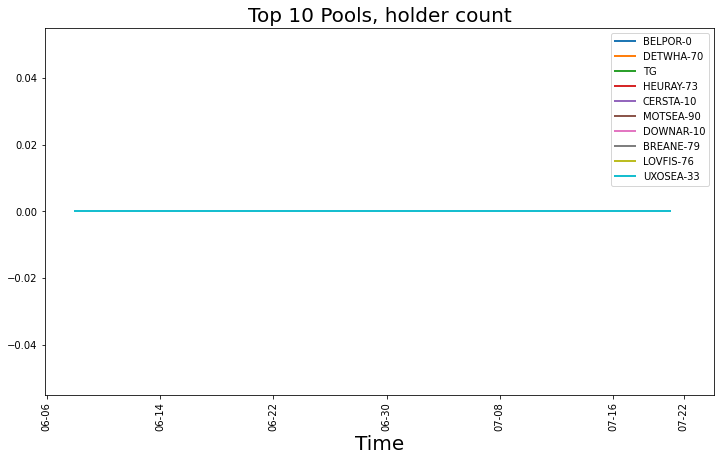

In [69]:
fig, ax = plt.subplots()
for pool in df_pools_sorted['id'][:10]:
    df = df_pools.loc[df_pools['id'] == pool]
    if df['datatoken.name'].unique()[0] is np.nan:
        datatoken_name = df['datatoken.name'].unique()[1]
    else:
        datatoken_name = df['datatoken.name'].unique()[0]

    if df['datatoken.symbol'].unique()[0] is np.nan:
        datatoken_symbol = df['datatoken.symbol'].unique()[1]
    else:
        datatoken_symbol = df['datatoken.symbol'].unique()[0]
    
    x = pd.to_datetime(df["timestamp"], unit='s').dt.strftime('%m-%d')

    y = df['datatoken.holderCount'].astype(float)
    plt.plot(x, y, label = f'{datatoken_symbol}', linewidth=2)

plt.xlabel("Time", fontsize=20)
# plt.ylabel("$OCEAN", fontsize=20)
plt.title(f"Top 10 Pools, holder count", fontsize=20)
plt.xticks(rotation=30)
plt.legend(fontsize=10)

ax.tick_params(axis='x',rotation=90)

ax.set_xticks(x[0::8])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

# Fixed rate exchanges (FRE)

In [8]:
df_datatokens

,address,block,createdTimestamp,dispensers,fixedRateExchanges,pools
0,0xb5d8d705524a18056216bf552fa7b473f852bf48,28944565,1653897180,0x257fe2e49530a4b7fc3ed597465e2931db3f20b7-0xb...,NaN,NaN
1,0x1c5d7f3c7c760d7d47823b0f0369940c71874e95,28979255,1653972787,0x257fe2e49530a4b7fc3ed597465e2931db3f20b7-0x1...,NaN,NaN
2,0x8b57ed8dcb403125912d4e8a4c15a6d50a517df2,28985213,1653985350,NaN,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...,NaN
3,0xddc5acf6b81520802adbf4f24e05de7fc2cac467,29064268,1654153299,0x257fe2e49530a4b7fc3ed597465e2931db3f20b7-0xd...,NaN,NaN
4,0xd3e5af97ac3ec333d6410ff807c217b090c88e61,29294034,1654645651,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a
...,...,...,...,...,...,...
328,0xa184dbb35d8fb38ad2405487178fa6921ec28100,31268448,1659081814,0x257fe2e49530a4b7fc3ed597465e2931db3f20b7-0xa...,NaN,NaN
329,0x12e5e590a7ab12f1d2e0f45cff2956840c72cf43,31275807,1659097781,NaN,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...,NaN
330,0x6f62705ea44d1770a96af3e51c9d86eee31733cc,31275865,1659097901,NaN,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x8...,NaN
331,0xa73c84b4036ba8e9a026bc439341a8743383fe66,31275935,1659098045,NaN,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x3...,NaN


In [10]:
df_datatokens_fres = df_datatokens.dropna(subset=['fixedRateExchanges']).reset_index(drop=True)


In [42]:
df_datatokens_fres['fixedRateExchanges']

0     0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...
1     0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x5...
2     0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...
3     0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x7...
4     0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...
                            ...                        
91    0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xb...
92    0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...
93    0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x8...
94    0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x3...
95    0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x7...
Name: fixedRateExchanges, Length: 96, dtype: object

In [44]:
df_data.shape

(1, 18)

In [80]:
for i in range(df_datatokens_fres.shape[0]): # still query all available pools
    fre = '"' + df_datatokens_fres['fixedRateExchanges'][i] + '"'
    # for j in range(df_timestamp_block.shape[0]):
    # for j in range(df_timestamp_block_origin.shape[0], df_timestamp_block.shape[0], 1): # recent timestamp-block
        # block = df_timestamp_block['block'][j]
        # timestamp = df_timestamp_block['timestamp'][j]
    query = \
    f"""
        {{
        fixedRateExchange(
            id: {fre}
            # block: {{
            # number: {block}
            # }}
        ) {{
            id
            datatokenSupply
            datatokenBalance
            price
            totalSwapValue
            datatoken {{
                address
                # templateId
                # isDatatoken
                name
                orderCount
                holderCount
                nft {{
                    creator
                    owner
                    name
                    symbol
                    transferable
                }}
            }}
            publishMarketSwapFee
        }}
        }}
        """
    headers = {"Content-Type": "application/json"}
    payload = json.dumps({"query": query})
    response = requests.request("POST", url, headers=headers, data=payload)

    data = json.loads(response.text)
    df_data = pd.json_normalize(data['data']['fixedRateExchange'])
    df_fres = pd.concat([df_fres, df_data], ignore_index=True, sort=False)
df_fres

,datatokenBalance,datatokenSupply,id,price,publishMarketSwapFee,totalSwapValue,datatoken.address,datatoken.holderCount,datatoken.name,datatoken.nft.creator,datatoken.nft.name,datatoken.nft.owner,datatoken.nft.symbol,datatoken.nft.transferable,datatoken.orderCount,block,timestamp
0,0,1157920892373161954235709850086879000000000000...,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x7...,1,0,0,0x2518e2579f85fdc0c11618ae847d6d59e4ccac66,0,Marvelous Clam Token,0x0363f3c31076a64b85ceb69a28f958a7c1181cee,Ocean Data NFT,0x0363f3c31076a64b85ceb69a28f958a7c1181cee,OCEAN-NFT,True,0,31294249.0,1.659139e+09
1,0,1000,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...,1,0.098,0,0x8b57ed8dcb403125912d4e8a4c15a6d50a517df2,0,Puckish Clam Token,0x9bf750b5465a51689fa4235aac1f37ec692ef7b4,Acentrik Asset Management,0x9bf750b5465a51689fa4235aac1f37ec692ef7b4,AAMT-8CE506D9,True,0,NaN,NaN
2,0,1000,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x5...,1,0.098,0,0xa066493a94676c2fe7473d63511586a98f46edb2,0,Petulant Shell Token,0x9bf750b5465a51689fa4235aac1f37ec692ef7b4,Acentrik Asset Management,0x9bf750b5465a51689fa4235aac1f37ec692ef7b4,AAMT-F5447163,True,2,NaN,NaN
3,0,1000,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...,1,0.098,0,0x2b0bb3a39c91be5812c9a7c42d5a935c8f23a9b6,0,Charming Swordfish Token,0x9bf750b5465a51689fa4235aac1f37ec692ef7b4,Acentrik Asset Management,0x9bf750b5465a51689fa4235aac1f37ec692ef7b4,AAMT-9F68FA07,True,1,NaN,NaN
4,0,1000,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x7...,1,0.098,0,0xf3cc4cf499f2fe23a3c2fdae81bf206cfa7e2cc7,0,Voluble Porpoise Token,0x6d3968da311d0c2ffdb13623151415efd262f175,Acentrik Asset Management,0x6d3968da311d0c2ffdb13623151415efd262f175,AAMT-1F4C35EA,True,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,1157920892373161954235709850086879000000000000...,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xb...,1,0,0,0x01cc3c186410c5ffea7ad6ec6ec33c02f05a299a,0,Gustatory Fugu Token,0x29ad2ad28abdabb877e5572b57219a594e21ebec,Ocean Data NFT,0x29ad2ad28abdabb877e5572b57219a594e21ebec,OCEAN-NFT,True,0,NaN,NaN
93,0,1157920892373161954235709850086879000000000000...,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...,1,0,0,0x12e5e590a7ab12f1d2e0f45cff2956840c72cf43,0,Optimistic Jellyfish Token,0x0363f3c31076a64b85ceb69a28f958a7c1181cee,Ocean Data NFT,0x0363f3c31076a64b85ceb69a28f958a7c1181cee,OCEAN-NFT,True,0,NaN,NaN
94,0,1157920892373161954235709850086879000000000000...,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x8...,1,0,0,0x6f62705ea44d1770a96af3e51c9d86eee31733cc,0,Optimistic Jellyfish Token,0x0363f3c31076a64b85ceb69a28f958a7c1181cee,Ocean Data NFT,0x0363f3c31076a64b85ceb69a28f958a7c1181cee,OCEAN-NFT,True,0,NaN,NaN
95,0,1157920892373161954235709850086879000000000000...,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x3...,1,0,0,0xa73c84b4036ba8e9a026bc439341a8743383fe66,0,Marvelous Clam Token,0x0363f3c31076a64b85ceb69a28f958a7c1181cee,Ocean Data NFT,0x0363f3c31076a64b85ceb69a28f958a7c1181cee,OCEAN-NFT,True,0,NaN,NaN


save

In [78]:
dt = datetime.now()
now_timestamp = int(datetime(
    year=dt.year, month=dt.month, day=dt.day, 
    hour=dt.hour, minute=dt.minute, second=dt.second, 
    microsecond=0, tzinfo=timezone.utc
).timestamp())

df_fres['timestamp'] = now_timestamp
df_fres.drop_duplicates(keep='first', inplace=True) 
df_fres.to_csv('./daily_data/fres.csv', index=False)

In [82]:
df_fres_sorted = pd.DataFrame(columns = ['id', 'price'])

for fre in df_fres['id'].unique():
    df = df_fres.loc[df_fres['id'] == fre]
    values = [{
        "id": fre,
        "price": df['datatoken.orderCount'].astype(float).max()
    }]
    df_fres_sorted = df_fres_sorted.append(values)

df_fres_sorted = df_fres_sorted.sort_values('price', ascending=False).reset_index(drop=True)
df_fres_sorted

,id,price
0,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xf...,5.0
1,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xa...,4.0
2,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xf...,4.0
3,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xd...,3.0
4,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xb...,2.0
...,...,...
91,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x9...,0.0
92,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x8...,0.0
93,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x4...,0.0
94,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0x2...,0.0
